<a href="https://colab.research.google.com/github/isabellacadisco/I-hate-you-P7-/blob/main/tests/shap_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install transformers datasets evaluate accelerate
%pip install optuna
dbutils.library.restartPython()

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.9 MB/s eta 0:00:00
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [ ]:
from transformers import AutoTokenizer
from datasets import load_dataset
from datasets.dataset_dict import DatasetDict
import evaluate
import numpy as np
from transformers import AutoModelForTokenClassification
import torch
from transformers import DataCollatorForTokenClassification
from transformers import Trainer
from transformers import TrainingArguments
from transformers import TrainerCallback

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.multiclass import unique_labels
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
from transformers import Trainer, TrainingArguments

2024-05-03 17:46:09.807700: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-03 17:46:09.807774: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-03 17:46:09.807799: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-03 17:46:09.819792: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

https://github.com/ellamguest/online-misogyny-eacl2021/tree/main/data
final_labels.csv: the dataset of agreed labels
https://github.com/ellamguest/online-misogyny-eacl2021

In [ ]:
path_en = '/dbfs/mnt/tesi/hs/final_labels.csv'

data_en = load_dataset("csv", data_files=path_en)

/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:45: UserWarning: The cache_dir for this dataset is /root/.cache, which is not a persistent path.Therefore, if/when the cluster restarts, the downloaded dataset will be lost.The persistent storage options for this workspace/cluster config are: [DBFS].Please update either `cache_dir` or the environment variable `HF_DATASETS_CACHE`to be under one of the following root directories: ['/dbfs/']
  warnings.warn(warning_message)
/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:14: UserWarning: During large dataset downloads, there could be multiple progress bar widgets that can cause performance issues for your notebook or browser. To avoid these issues, use `datasets.utils.logging.disable_progress_bar()` to turn off the progress bars.
  warnings.warn(


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

https://github.com/valeriavla/workshop_misogyny/blob/main/labeled_tweets.csv


In [ ]:
path_es = '/dbfs/mnt/tesi/hs/labeled_tweets.csv'

data_es = load_dataset("csv", data_files=path_es)

/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:45: UserWarning: The cache_dir for this dataset is /root/.cache, which is not a persistent path.Therefore, if/when the cluster restarts, the downloaded dataset will be lost.The persistent storage options for this workspace/cluster config are: [DBFS].Please update either `cache_dir` or the environment variable `HF_DATASETS_CACHE`to be under one of the following root directories: ['/dbfs/']
  warnings.warn(warning_message)
/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:14: UserWarning: During large dataset downloads, there could be multiple progress bar widgets that can cause performance issues for your notebook or browser. To avoid these issues, use `datasets.utils.logging.disable_progress_bar()` to turn off the progress bars.
  warnings.warn(


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

In [ ]:
data_es['train']

Dataset({
    features: ['Unnamed: 0', 'tweets', 'label'],
    num_rows: 10029
})

In [ ]:
data_en['train'][0]

{'entry_id': 'exoxn7',
 'link_id': 't3_exoxn7',
 'parent_id': None,
 'entry_utc': 1580652620,
 'subreddit': 'badwomensanatomy',
 'author': 'doggodone',
 'body': 'Do you have the skin of a 80 year old grandma? Worry no more, just drink water!',
 'image': 'Yes',
 'label_date': '17-02-2020',
 'week': 1,
 'group': 1,
 'sheet_order': '(1,)',
 'level_1': 'Nonmisogynistic',
 'level_2': 'None_of_the_categories',
 'level_3': None,
 'strength': None,
 'highlight': None,
 'split': 'train'}

In [ ]:
data_en

DatasetDict({
    train: Dataset({
        features: ['entry_id', 'link_id', 'parent_id', 'entry_utc', 'subreddit', 'author', 'body', 'image', 'label_date', 'week', 'group', 'sheet_order', 'level_1', 'level_2', 'level_3', 'strength', 'highlight', 'split'],
        num_rows: 6567
    })
})

In [ ]:
data_en = data_en.remove_columns(['link_id', 'parent_id', 'entry_utc', 'subreddit', 'author', 'image', 'label_date', 'week', 'group', 'sheet_order', 'level_2', 'level_3', 'strength', 'highlight'])

In [ ]:
data_es = data_es.remove_columns(['Unnamed: 0'])

In [ ]:
data_en

DatasetDict({
    train: Dataset({
        features: ['entry_id', 'body', 'level_1', 'split'],
        num_rows: 6567
    })
})

In [ ]:
data_en_train = data_en.filter(lambda example: example['split'] == 'train')

Filter:   0%|          | 0/6567 [00:00<?, ? examples/s]

In [ ]:
data_en_train

DatasetDict({
    train: Dataset({
        features: ['entry_id', 'body', 'level_1', 'split'],
        num_rows: 5264
    })
})

In [ ]:
data_en_train = data_en_train.remove_columns(['split'])

In [ ]:
data_en_train

DatasetDict({
    train: Dataset({
        features: ['entry_id', 'body', 'level_1'],
        num_rows: 5264
    })
})

In [ ]:
data_en_val_test = data_en.filter(lambda example: example['split'] == 'test')

Filter:   0%|          | 0/6567 [00:00<?, ? examples/s]

In [ ]:
data_en_val_test = data_en_val_test.remove_columns(['split'])

In [ ]:
data_en_val_test

DatasetDict({
    train: Dataset({
        features: ['entry_id', 'body', 'level_1'],
        num_rows: 1303
    })
})

In [ ]:
data_es

DatasetDict({
    train: Dataset({
        features: ['tweets', 'label'],
        num_rows: 10029
    })
})

In [ ]:
data_es = data_es.rename_column("tweets", "text")

In [ ]:
data_es

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 10029
    })
})

In [ ]:
train_test = data_es['train'].train_test_split(test_size=0.2, seed=42)

misoginy detection using mexican tweets

In [ ]:
train_test

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 8023
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2006
    })
})

LLM fine tuning

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

In [ ]:
tokenized_data = train_test.map(preprocess_function, batched=True)

Map:   0%|          | 0/8023 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/2006 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import evaluate

accuracy = evaluate.load("accuracy")

In [ ]:
import numpy as np


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1} #se va cambiarle

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifier.bias', 'pre_classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="/dbfs/mnt/ds-documents/Tesi/prova_tm/misoginy_det",
    learning_rate=2e-5,
    num_train_epochs=2,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,

    logging_first_step=True,
    fp16=True,
    auto_find_batch_size=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_data["train"],
    eval_dataset=tokenized_data["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.346300,0.588322,0.815553
2,0.299100,0.563603,0.827517


TrainOutput(global_step=2006, training_loss=0.3312101257168284, metrics={'train_runtime': 219.0799, 'train_samples_per_second': 73.243, 'train_steps_per_second': 9.156, 'total_flos': 218518938607616.0, 'train_loss': 0.3312101257168284, 'epoch': 2.0})

In [ ]:
%sh
cd /dbfs/mnt/ds-documents/Tesi/prova_tm/misoginy_det
ls

checkpoint-1003
checkpoint-2006
runs


In [ ]:
my_model_pt =  '/dbfs/mnt/ds-documents/Tesi/prova_tm/misoginy_det/checkpoint-2006'

In [ ]:
torch.cuda.empty_cache()

In [ ]:
my_model = AutoModelForSequenceClassification.from_pretrained(
    my_model_pt,
    id2label=id2label,
    label2id=label2id,
).cuda()


In [ ]:
from transformers import pipeline

In [ ]:
import shap

In [ ]:
# build a pipeline object to do predictions
pred = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    device=0,
    top_k=None,
)

In [ ]:
explainer = shap.Explainer(pred)

In [ ]:
shap_values = explainer(tokenized_data["test"][:50])

PartitionExplainer explainer: 51it [01:39,  2.17s/it]


In [ ]:
shap.plots.text(shap_values)

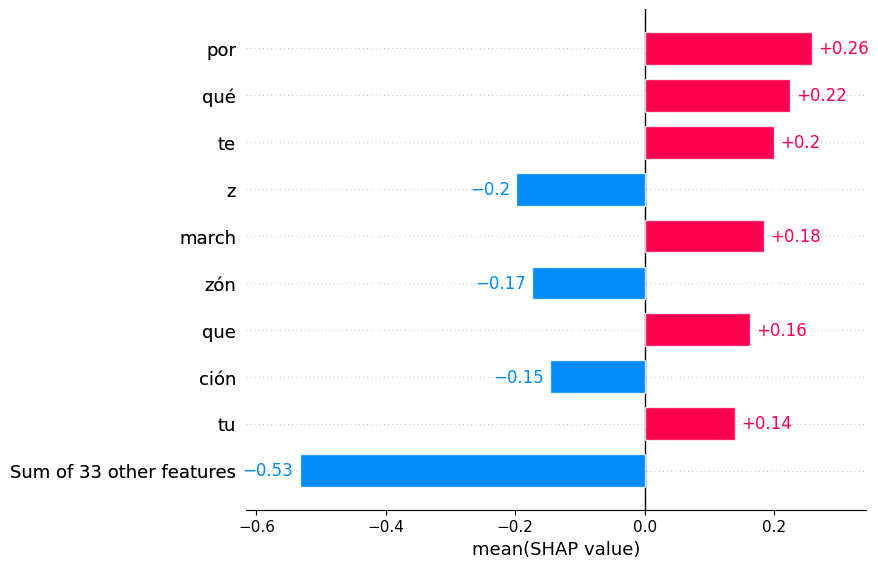

In [ ]:
shap.plots.bar(shap_values[:, :, "POSITIVE"].mean(0))

In [ ]:
shap_values[:, :, "POSITIVE"].mean(0)

.values =
array([ 0.        ,  0.0670073 ,  0.07925868,  0.25836115,  0.22483558,
        0.18444173, -0.08952859, -0.02741078, -0.04438299,  0.05276543,
       -0.03783758, -0.06743071,  0.0340119 , -0.11465098,  0.16215119,
        0.2001315 ,  0.10393912,  0.09335392, -0.0569168 , -0.0533313 ,
       -0.01239341, -0.07194404, -0.14559029, -0.07834923, -0.13273984,
       -0.08129138, -0.01090892,  0.08483988,  0.13436736,  0.14004809,
       -0.00178198, -0.04462226, -0.00532951,  0.0077934 , -0.04441608,
        0.0187488 , -0.02723316, -0.07222163, -0.17395661, -0.10186657,
       -0.03286644, -0.1981657 ])

.base_values =
0.27717939019203186

.data =
array(['', 'sa', 'bes ', 'por ', 'qué ', 'march', 'amo', 's ', 'el ',
       'pas', 'ado ', '28', 's', ''], dtype='<U5')